In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import re
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [3]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
imp_type

impression type  imp_type_id
0          display            1
1            video            2
2           native            4
3     native video            8
4   rewarded video           16
5              IBV           32
6  rewarded banner           64

In [142]:
start_dt = '2021-07-15'
end_dt = '2021-08-04'


Estimate revenue increase from migration change

In [143]:
df = bigquery_client.query(f"""
select
    r.date
    , c.name as campaign_name    
    , r.ssb_campaign_uuid
    , r.ssb_buyer_id
    , r.sponsored_app_id
    , p.name as sponsored_app_name
    , r.exchange_id
    , p.bundle as sponsored_bnd
    , count(case when event_type = 'clear' then 1 else NULL end)*2 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*2 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*2 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*2 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*2/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*2/1000 as bid
from stats.rows1 r
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid  
join metadata.apps p
    on r.sponsored_app_id = p.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.id,1) in ('0','1','2','3','4','5','6','7')
group by 1,2,3,4,5,6,7,8
""").to_dataframe()
# df = df.set_index('imp_type').join(imp_type.set_index('imp_type_id'), how = 'left').reset_index()
df = df.set_index('exchange_id').join(exchange.set_index('exchange_id'), how = 'left').reset_index()
df['experience_type'] = df.apply(lambda x:classify_campaigns(x), axis = 1)
df['media_cost'] = 1.25*df['cost']
df['date'] = pd.to_datetime(df['date'])
df['week'] = df.date.dt.week
df

exchange_id       date                            campaign_name  \
0                1 2021-07-16           Targeted App Categories - US_2   
1                1 2021-07-28         72550 - Fetch iOS Agency AF Test   
2                1 2021-07-31    Android-Papaya Games-Solitaire Cash-4   
3                1 2021-07-17  Credit Sesame - Credit Sesame - UA – US   
4                1 2021-07-28                    Blob Runner 3D_US_DRD   
...            ...        ...                                      ...   
67783           59 2021-07-24  Solitaire_android_Appreciate_DSP_Banner   
67784           59 2021-08-04   Solitaire_android_Appreciate_DSP_Video   
67785           59 2021-07-28      Solitaire_android_US_DSP_Appreciate   
67786           59 2021-08-03   Solitaire_android_Appreciate_DSP_Video   
67787           59 2021-07-26      Solitaire_android_US_DSP_Appreciate   

                      ssb_campaign_uuid  ssb_buyer_id  sponsored_app_id  \
0      9f1030143086f60252762b45e384b154          2139            464418   
1      01f37cdd93ad8b4ff8f8027a2827aff8          1430        1182474649   
2      8b1493dacec7f61aa46ca190b0973853          3549           1281416   
3      d8ee55bb6a1ac49f92211ed4a9313f85          3549            432453   
4      30f37ccf4b77bf3a1397eda780b9fd2a          3246           1256875   
...                                 ...           ...               ...   
67783  dc249c85b5396c26726a935ca6366db8          2569           1030655   
67784  2469a82169b69d99828b22c92cf42dd7          2569           1030655   
67785  09bc68bc1291c05cd304c46bd145ac63          2569           1030655   
67786  2469a82169b69d99828b22c92cf42dd7          2569           1030655   
67787  09bc68bc1291c05cd304c46bd145ac63          2569           1030655   

                                     sponsored_app_name  \
0      TextNow - Free Text, Voice and Video Calling App   
1                         Fetch: Rewards and Gift Cards   
2                                        solitaire cash   
3          Credit Sesame: Credit Score & Mobile Banking   
4                                        Blob Runner 3D   
...                                                 ...   
67783                                         Solitaire   
67784                                         Solitaire   
67785                                         Solitaire   
67786                                         Solitaire   
67787                                         Solitaire   

                     sponsored_bnd  impressions  clicks  installs  spend  \
0      com.enflick.android.TextNow        28510     146        22   33.0   
1                       1182474649       264084    3088        52  104.0   
2         com.papaya.solitairecash        80766    3236         0    0.0   
3                 com.creditsesame        50194     852        94  470.0   
4              com.quok.blobRunner        12698      58        14    4.2   
...                            ...          ...     ...       ...    ...   
67783      com.tripledot.solitaire          764      10         0    0.0   
67784      com.tripledot.solitaire         1246      50         2   14.0   
67785      com.tripledot.solitaire          206       4         0    0.0   
67786      com.tripledot.solitaire          756      20         0    0.0   
67787      com.tripledot.solitaire          378      10         2   15.0   

             cost         bid exchange_name  experience_type  media_cost  week  
0       24.731243   27.048373         Fyber               -1   30.914054    28  
1       98.083980  125.923151         Fyber               -1  122.604975    30  
2      319.843593  319.859498         Fyber                4  399.804491    30  
3      223.815730  384.073665         Fyber                2  279.769662    28  
4       10.158811   10.162418         Fyber               -1   12.698514    30  
...           ...         ...           ...              ...         ...   ...  
67783    8.059598    8.06175

In [144]:
migration = pd.read_excel('files/Audience_Migration.xlsx')
migration['migration_date'] = pd.to_datetime(migration['Done (PDT)'], errors = 'coerce')
migration = migration.loc[(migration.migration_date >= datetime.datetime(2021,7,20)) & (migration.migration_date <= datetime.datetime(2021,7,27)), ['campaign_uuid','migration_date']]
migration.rename(columns = {'campaign_uuid':'ssb_campaign_uuid'}, inplace = True)
migration['migration_date'] = pd.to_datetime(migration['migration_date'])
migration

ssb_campaign_uuid migration_date
29  95f82f59fd9cac3b272b560f722e35d6     2021-07-20
30  6d5f7270a4335e186b77a6c6d3cc5161     2021-07-20
31  16d935fca4ea8b4dffa296ba147ec7df     2021-07-20
32  5d294c23d51b0c64a63275f4b8412067     2021-07-20
33  c5534bbfcb4dccdd122f22da877a6f78     2021-07-20
..                               ...            ...
86  292906bbb71deaebb880439ce8c72995     2021-07-27
87  7a4215912066a0d346cfbc65f36884aa     2021-07-27
88  3d49799460091904856b1753e55330ba     2021-07-27
89  2941f84305e855adfd667924416ec99d     2021-07-27
90  d09e58a29ebc1e9c5a041603dfef64d7     2021-07-27

[62 rows x 2 columns]

In [145]:
days_comparison = 7

df = df[[col for col in df.columns if 'migration_date' not in col]]
df_joined = pd.merge(df, migration, on = 'ssb_campaign_uuid')

def classify_dates(x):
    if x.days_from_change <= days_comparison and x.days_from_change > 0:
        return 'post'
    elif x.days_from_change >= -days_comparison and x.days_from_change < 0:
        return 'pre'
    else:
        return np.nan

df_joined['days_from_change'] = df_joined.apply(lambda x:(x.date - x.migration_date).days, axis = 1)
df_joined['date_range'] = df_joined.apply(lambda x:classify_dates(x), axis = 1)
df_joined

exchange_id       date                 campaign_name  \
0                1 2021-07-16  Stars Group-Poker Stars-BR-2   
1                1 2021-07-25  Stars Group-Poker Stars-BR-2   
2                1 2021-07-29  Stars Group-Poker Stars-BR-2   
3                1 2021-07-19  Stars Group-Poker Stars-BR-2   
4                1 2021-07-28  Stars Group-Poker Stars-BR-2   
...            ...        ...                           ...   
11903           56 2021-07-15        Android-Wish-Wish-US-3   
11904           56 2021-07-24        Android-Wish-Wish-US-3   
11905           56 2021-07-16        Android-Wish-Wish-US-3   
11906           56 2021-07-26        Android-Wish-Wish-US-3   
11907           56 2021-07-17        Android-Wish-Wish-US-3   

                      ssb_campaign_uuid  ssb_buyer_id  sponsored_app_id  \
0      d71c42106c0bce1ab4ec672121dfe9a6          3549           1028577   
1      d71c42106c0bce1ab4ec672121dfe9a6          3549           1028577   
2      d71c42106c0bce1ab4ec672121dfe9a6          3549           1028577   
3      d71c42106c0bce1ab4ec672121dfe9a6          3549           1028577   
4      d71c42106c0bce1ab4ec672121dfe9a6          3549           1028577   
...                                 ...           ...               ...   
11903  2941f84305e855adfd667924416ec99d          3549            446441   
11904  2941f84305e855adfd667924416ec99d          3549            446441   
11905  2941f84305e855adfd667924416ec99d          3549            446441   
11906  2941f84305e855adfd667924416ec99d          3549            446441   
11907  2941f84305e855adfd667924416ec99d          3549            446441   

             sponsored_app_name                   sponsored_bnd  impressions  \
0                pokerstars com  com.pyrsoftware.pokerstars.com        24456   
1                pokerstars com  com.pyrsoftware.pokerstars.com        38900   
2                pokerstars com  com.pyrsoftware.pokerstars.com       121626   
3                pokerstars com  com.pyrsoftware.pokerstars.com        24590   
4                pokerstars com  com.pyrsoftware.pokerstars.com       138602   
...                         ...                             ...          ...   
11903  Wish - Shopping Made Fun           com.contextlogic.wish          106   
11904  Wish - Shopping Made Fun           com.contextlogic.wish            2   
11905  Wish - Shopping Made Fun           com.contextlogic.wish           86   
11906  Wish - Shopping Made Fun           com.contextlogic.wish            2   
11907  Wish - Shopping Made Fun           com.contextlogic.wish           34   

       clicks  ...  spend        cost         bid  exchange_name  \
0         618  ...   64.0   22.640495   28.822314          Fyber   
1        1112  ...  176.0   32.031567   37.163159          Fyber   
2        4258  ...  478.0  143.635865  161.478867          Fyber   
3         612  ...   58.0   26.256463   34.025218          Fyber   
4        5238  ...  594.0  195.156737  228.798361          Fyber   
...       ...  ...    ...         ...         ...            ...   
11903       2  ...    4.0    1.389767    1.389055        Algorix   
11904       0  ...    0.0    0.001140    0.001139        Algorix   
11905       4  ...    0.0    0.127179    0.127097        Algorix   
11906       0  ...    0.0    0.001100    0.001100        Algorix   
11907       0  ...    0.0    0.015758    0.015654        Algorix   

      experience_type  media_cost  week  migration_date days_from_change  \
0                   2   28.300618    28      2021-07-27              -11   
1                   2   40.039459    29      2021-07-27               -2   
2                   2  179.544832    30      2021-07-27                2   
3                   2   32.820579    29      2021-07-27               -8   
4                   2  243.945921    30      2021-07-27                1   
...               ...         ...   ...             ...              ...   
11903               3    1.737209    28

In [146]:
def calc_metrics(df, sov_base = 0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['media_cost']/df['impressions']
    df['rpi'] = df['spend']/df['installs']
    df['margin'] = 100*(df['spend']-df['media_cost'])/df['spend']
    
    if sov_base == 0:
        df['media_cost_sov'] = 100*df['media_cost']/df['media_cost'].sum()
        df['spend_sov'] = 100*df['spend']/df['spend'].sum()
    else:
        df['media_cost_sov'] = 100*df['media_cost']/df.groupby(sov_base)['media_cost'].transform(sum)
        df['spend_sov'] = 100*df['spend']/df.groupby(sov_base)['spend'].transform(sum)
        
    df['cost_increase'] = 100*(df['media_cost']/df.loc[df.index.get_level_values(0) == 'pre','media_cost'].mean())-100
    df['spend_increase'] = 100*(df['spend']/df.loc[df.index.get_level_values(0) == 'pre','spend'].mean())-100
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','spend','spend_sov','spend_increase','media_cost','media_cost_sov','cost_increase','margin']]

format_map = {'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'d7_retent':'{:,.0f}'
             ,'spend':'${:,.0f}'
             ,'media_cost':'${:,.0f}'
             ,'rpi':'${:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'cost_increase':'{:,.0f}%'
             ,'spend_increase':'{:,.0f}%'
             ,'spend_sov':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'media_cost_sov':'{:,.0f}%'}

In [147]:
i = ['date_range']
pivot = df_joined.pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot.sort_values(['date_range'], ascending = False, inplace = True)
format_pivot.style.format(format_map)

In [211]:
i = ['days_from_change']
filters = (abs(df_joined.days_from_change) <= days_comparison)
pivot = df_joined[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot.sort_values(['days_from_change'], ascending = [True], inplace = True)
format_pivot.style.format(format_map)

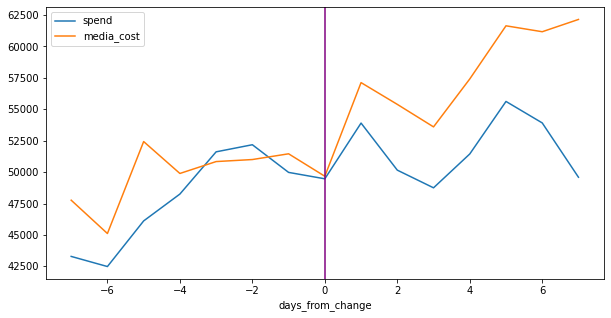

In [212]:
format_pivot[['spend','media_cost']].plot(figsize = (10,5))
plt.gca().axvline(x=0, color = 'purple')

In [208]:
i = ['campaign_name','date_range']
pivot = df_joined.pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot['total_cost'] = format_pivot.groupby(i[0])['media_cost'].transform(sum)
format_pivot.sort_values(['total_cost','date_range'], ascending = False, inplace = True)
top_bnds = format_pivot.index.get_level_values(0).drop_duplicates().tolist()[:20]
format_pivot.head(30).style.format(format_map)

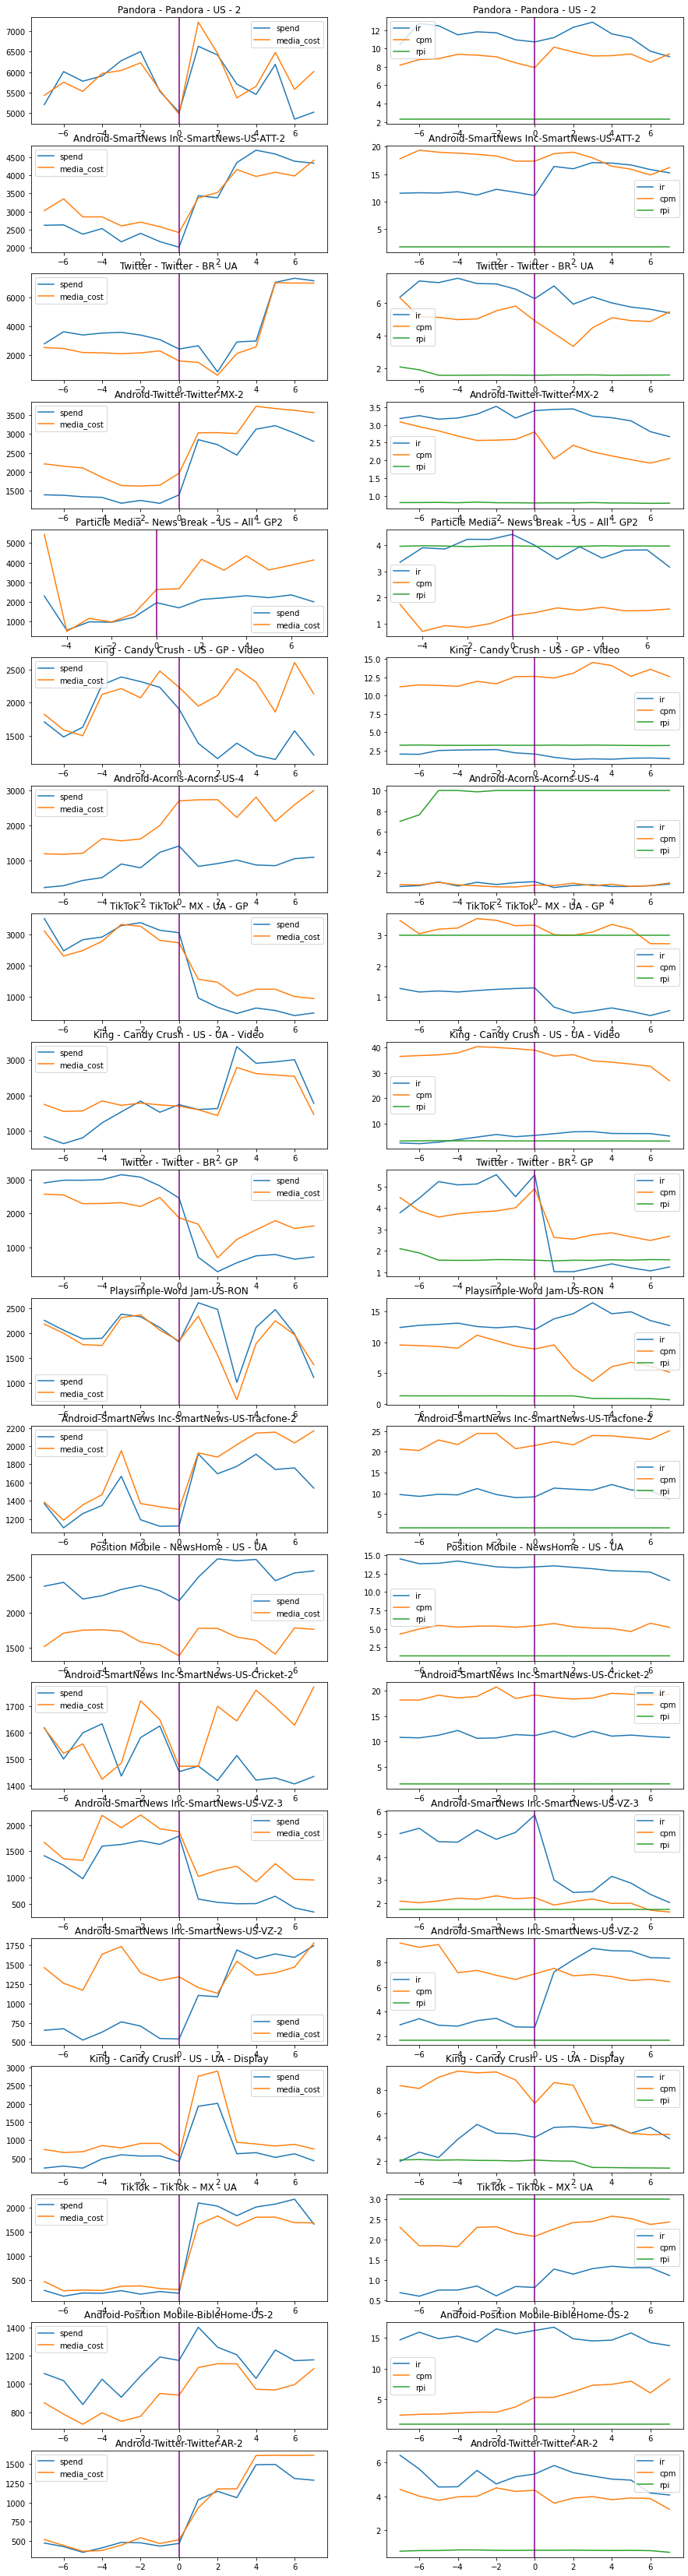

In [209]:

fig, ax = plt.subplots(len(top_bnds),2, figsize = (15,len(top_bnds)*3))

for i in range(len(top_bnds)):
    bnd = top_bnds[i]
    filters = (df_joined.campaign_name == bnd) & (abs(df_joined.days_from_change) <= days_comparison)
    pivot = df_joined[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = 'days_from_change', aggfunc = np.sum)
    format_pivot = calc_metrics(pivot)
    format_pivot.sort_values(['days_from_change'], ascending = [True], inplace = True)

    ax[i,0].plot(format_pivot.loc[:,['spend','media_cost']])
    ax[i,0].legend(['spend','media_cost'])
    ax[i,0].set_title(bnd)
    ax[i,0].axvline(x = 0, color = 'purple')
    ax[i,1].set_title(bnd)
    ax[i,1].plot(format_pivot.loc[:,['ir','cpm','rpi']])
    ax[i,1].axvline(x=0, color = 'purple')
    ax[i,1].legend(['ir','cpm','rpi'])

The drops are all from experience 3 campaigns:

In [237]:
filters = (abs(df_joined.days_from_change) <= days_comparison)
pivot = df_joined[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = ['experience_type','date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot.sort_values(['experience_type','date_range'], ascending = True, inplace = True)
format_pivot[['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','spend','media_cost','margin']].style.format(format_map)

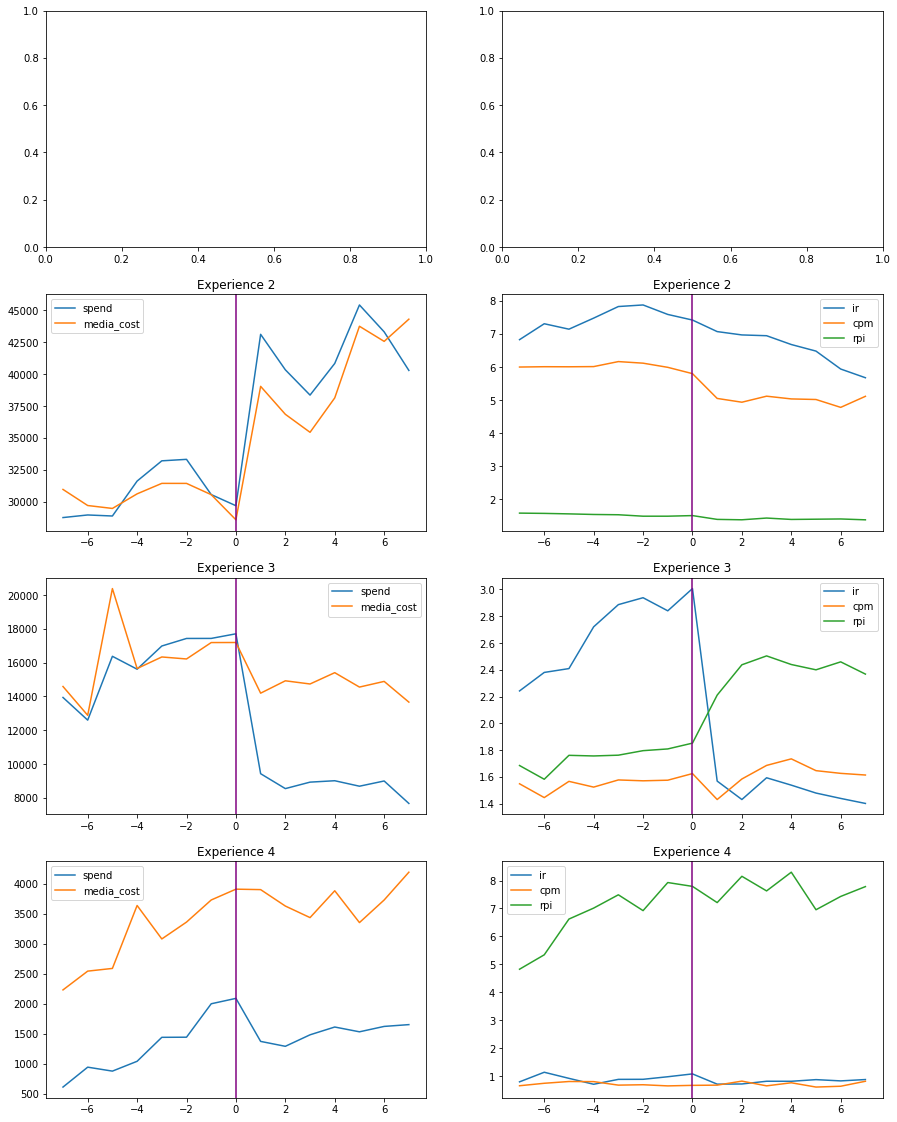

In [230]:
fig, ax = plt.subplots(4,2,figsize = (15,20))
for i in range(2,5):
    filters = (df_joined.experience_type == i) & (abs(df_joined.days_from_change) <= days_comparison)
    pivot = df_joined[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = 'days_from_change', aggfunc = np.sum)
    format_pivot = calc_metrics(pivot)
    format_pivot.sort_values(['days_from_change'], ascending = [True], inplace = True)

    ax[i-1,0].plot(format_pivot.loc[:,['spend','media_cost']])
    ax[i-1,0].legend(['spend','media_cost'])
    ax[i-1,0].set_title(f'Experience {i}')
    ax[i-1,0].axvline(x = 0, color = 'purple')
    ax[i-1,1].set_title(f'Experience {i}')
    ax[i-1,1].plot(format_pivot.loc[:,['ir','cpm','rpi']])
    ax[i-1,1].axvline(x=0, color = 'purple')
    ax[i-1,1].legend(['ir','cpm','rpi'])

In [ ]:
i = ['days_from_change']
n=7
filters = (df_joined.campaign_name == 'TikTok – TikTok – MX - UA - GP') & (abs(df_joined.days_from_change) <= days_comparison)
pivot = df_joined[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot.sort_values(['days_from_change'], ascending = [True], inplace = True)
print('TikTok – TikTok – MX - UA - GP')
format_pivot.style.format(format_map)